In [8]:
from __future__ import division #always returns approximations from divisions
import numpy as np
import matplotlib.pyplot as plt
import ephem #for astronomy calculations, converting coordinate systems
import pandas as pd
from astroquery.gaia import Gaia
import math

In [9]:
v_df = pd.read_csv('pio10_ephemeris.csv') #pioneer 10 ephemeris 
s_df = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt']) #empty dataframe for encountered stars

In [10]:
v_df['year'] = 0
v_df['month'] = 0
v_df['day'] = 0
v_df['hour'] = 0
v_df['min'] = 0
v_df['sec'] = 0
v_df['total_time'] = 0
v_df['time_lasts'] = 0

for i in range(len(v_df.index)):
    v_df['year'][i] = float(v_df['date'][i][:4])
    v_df['month'][i] = v_df['date'][i][5:8]
    v_df['day'][i] = float(v_df['date'][i][9:11])
    v_df['hour'][i] = float(v_df['date'][i][12:14])
    v_df['min'][i] = float(v_df['date'][i][15:17])
    v_df['sec'][i] = v_df['date'][i][18:]
    
    if v_df['month'][i] == "Jan":
        v_df['month'][i] = 0
        
    elif v_df['month'][i] == "Feb":
        v_df['month'][i] = 1
        
    elif v_df['month'][i] == "Mar":
        v_df['month'][i] = 2
        
    elif v_df['month'][i] == "Apr":
        v_df['month'][i] = 3
        
    elif v_df['month'][i] == "May":
        v_df['month'][i] = 4
        
    elif v_df['month'][i] == "Jun":
        v_df['month'][i] = 5
        
    elif v_df['month'][i] == "Jul":
        v_df['month'][i] = 6
        
    elif v_df['month'][i] == "Aug":
        v_df['month'][i] = 7
        
    elif v_df['month'][i] == "Sep":
        v_df['month'][i] = 8
        
    elif v_df['month'][i] == "Oct":
        v_df['month'][i] = 9
        
    elif v_df['month'][i] == "Nov":
        v_df['month'][i] = 10
        
    elif v_df['month'][i] == "Dec":
        v_df['month'][i] = 11
    
    #calc total time (since 0/0/0) in seconds
    v_df['total_time'][i] = v_df['year'][i] * 31536000 + v_df['month'][i] * 2628288 + v_df['day'][i] * 86400 + v_df['hour'][i] * 3600 + v_df['min'][i] * 60 + float(v_df['sec'][i])
    
for i in range(len(v_df.index)-1):    
    v_df['time_lasts'][i] = v_df['total_time'][i+1] - v_df['total_time'][i]
    
print(v_df)

<ipython-input-10-bdaabe8958ac>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['year'][i] = float(v_df['date'][i][:4])
<ipython-input-10-bdaabe8958ac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['month'][i] = v_df['date'][i][5:8]
/Users/mikeyd1050/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-inp

      Unnamed: 0                      date         ra       dec  year month  \
0              0  1972-Mar-04 00:00:00.000  246.80935 -30.75413  1972     2   
1              1  1972-Mar-04 03:39:27.015  246.93610 -30.76865  1972     2   
2              2  1972-Mar-04 08:36:11.068  247.06011 -30.78274  1972     2   
3              3  1972-Mar-04 15:35:33.602  247.18058 -30.79634  1972     2   
4              4  1972-Mar-05 02:03:50.743  247.29634 -30.80933  1972     2   
...          ...                       ...        ...       ...   ...   ...   
3039           5  2002-Nov-27 14:58:14.767   76.23570  25.91528  2002    10   
3040           6  2002-Dec-08 16:23:12.817   76.09205  25.90360  2002    11   
3041           7  2002-Dec-19 11:45:12.663   75.95159  25.89067  2002    11   
3042           8  2002-Dec-30 11:54:11.621   75.81409  25.87648  2002    11   
3043           9  2003-Jan-11 04:07:27.709   75.68049  25.86096  2003     0   

      day  hour  min     sec   total_time  time_las

In [4]:
#Cone search using max radius on first position in ephemeris
for i in range(len(v_df.index)):
    query = """SELECT source_id, ra, dec, phot_g_mean_mag+5*log10(parallax/1000)+5 AS g_abs, (phot_bp_mean_mag - phot_rp_mean_mag) AS bp_rp, parallax, parallax_error, 1000/parallax AS dist, pmra, pmdec
    FROM external.gaiaedr3_gcns_main_1
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.4527778))
    AND parallax > 0
    """

    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    results['date'] = v_df['date'][i]
    results['eph_pt'] = i; #stores which row in ephemeris from

    s_df = pd.concat([s_df, results], ignore_index = True)

print(s_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
#Advance stars in list with motion
s_df['adv_ra'] = s_df['ra'] + 3.26*s_df['dist']*s_df['pmra']/1000*(0.000277778)
s_df['adv_dec'] = s_df['dec'] + 3.26*s_df['dist']*s_df['pmdec']/1000*(0.000277778)

print(s_df)

                 source_id          ra        dec      g_abs     bp_rp  \
0      6025604409224636800  247.088433 -31.131545   6.164488  1.170948   
1      6037702846755772800  246.557303 -30.534852   8.616544  2.069988   
2      6037783179823439744  246.853672 -30.468497   9.217234  2.306777   
3      6025778338222506240  247.018927 -30.489735  12.404579  3.307764   
4      6025779089827713408  247.172497 -30.472956   9.078292  1.988196   
...                    ...         ...        ...        ...       ...   
16641  3420035801576292224   76.101635  25.518620   9.603711  2.554008   
16642  3420081976769085696   76.544261  25.598656  14.914568  3.088478   
16643  3420035801576292224   76.101635  25.518620   9.603711  2.554008   
16644  3420035801576292224   76.101635  25.518620   9.603711  2.554008   
16645  3420035801576292224   76.101635  25.518620   9.603711  2.554008   

        parallax  parallax_error        dist                      date  \
0      35.542473        0.019770   28

In [6]:
#Check that advanced ra and dec are within actual cone

final_stars = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt'])

for i in range(len(s_df.index)):
    dist = math.sqrt((v_df['ra'][s_df['eph_pt'][i]] - s_df['adv_ra'][i])**2 + (v_df['dec'][s_df['eph_pt'][i]] - s_df['adv_dec'][i])**2) #calculate distance between advanced position and center of beam
    
    if dist < 0.064: #if distance < radius of beam add to final version
        final_stars = final_stars.append(s_df.loc[s_df['source_id'] == s_df['source_id'][i]]) #add star to final version     

In [11]:
final_stars = pd.read_csv('pio10_stars_final_dup.csv') #final stars from above were saved in this file

final_stars['time_total'] = 0
final_stars = final_stars[final_stars['dist'] <= 100] #eliminate stars not in 100 pc

final_stars['num'] = 0 

for i in range(len(final_stars.index)):
    final_stars['num'][i] = i  #index of stars
    final_stars['time_total'][i] = v_df['time_lasts'][final_stars['eph_pt'][i]] #time for each search based on ephemeris pt time lasts
    
final_stars = final_stars.drop(['Unnamed: 0'], axis = 1) #drop extra column
    
final_stars.to_csv('pio10_stars_final_dup.csv') #save again 
print(final_stars) #all stars with duplicates

final_stars_unique = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt', 'time_total'])

<ipython-input-11-14774443efef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stars['num'][i] = i  #index of stars
<ipython-input-11-14774443efef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stars['time_total'][i] = v_df['time_lasts'][final_stars['eph_pt'][i]] #time for each search based on ephemeris pt time lasts


                source_id          ra        dec      g_abs     bp_rp  \
0     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
1     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
2     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
3     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
4     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
...                   ...         ...        ...        ...       ...   
4787  3420282985533933824   74.990215  25.854341   9.308213  2.277160   
4788  3420282985533933824   74.990215  25.854341   9.308213  2.277160   
4789  3420282985533933824   74.990215  25.854341   9.308213  2.277160   
4790  3420282985533933824   74.990215  25.854341   9.308213  2.277160   
4791  3420282985533933824   74.990215  25.854341   9.308213  2.277160   

       parallax  parallax_error       dist                      date  \
0     11.812105        0.099880  84.658914  1972-Ap

In [12]:
num_hit = np.array([])     #number of times a star appears in search, index matches
total_times = np.array([])     #array of total times for each star, index matches

for i in range(len(final_stars.index)):
    if (final_stars['source_id'][i] not in final_stars_unique[['source_id']].to_numpy()):   #if star not in unique database
        final_stars_unique = final_stars_unique.append(final_stars.loc[final_stars['num'] == i]) #add star to unique df
        
        num_hit = np.append(num_hit, 1)  #add 1 hit
        
        total_time = final_stars['time_total'][i]   #add value to total time
        
        for j in range(i+1, len(final_stars.index)):   #search from next star in final_stars to end
            
            if final_stars['source_id'][j] == final_stars['source_id'][i]:    #if same star appears again add time and increase number of hits by 1
                total_time += final_stars['time_total'][j]
                num_hit[-1] += 1
                
        total_times = np.append(total_times, total_time)    #add total time to total times array

final_stars_unique['time_total'] = total_times.tolist()    #add total times and num hit as columns
final_stars_unique['num_hit'] = num_hit.tolist()
print(final_stars_unique)  #dataframe of stars without duplicates and with total times & num hits

                source_id          ra        dec      g_abs     bp_rp  \
0     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
7     6040374526875038336  240.886424 -29.236631  10.509056  2.507523   
14    6040379371598261888  240.704638 -29.159567  10.107287  2.686555   
21    6233452028580863744  236.874676 -27.919921  10.172965  2.460388   
28    6233827481743360128  236.895873 -27.895120  12.779029  3.660349   
...                   ...         ...        ...        ...       ...   
4053   147476395122921600   71.506742  25.497324  15.775414  2.129372   
4140   147469115153030528   71.982516  25.579519   9.977690  2.725558   
4433   153279243832437376   74.081388  25.695916  12.402469  3.047662   
4533  3419918875386344576   74.532503  25.805848  12.564852  0.090281   
4669  3420282985533933824   74.990215  25.854341   9.308213  2.277160   

       parallax  parallax_error       dist                      date  \
0     11.812105        0.099880  84.658914  1972-Ap

In [13]:
final_stars_unique.to_csv('pio10_results_error.csv') #save again 

In [14]:
print(final_stars.drop_duplicates(subset=['source_id'])) #checking that unique search works, same number

                source_id          ra        dec      g_abs     bp_rp  \
0     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
7     6040374526875038336  240.886424 -29.236631  10.509056  2.507523   
14    6040379371598261888  240.704638 -29.159567  10.107287  2.686555   
21    6233452028580863744  236.874676 -27.919921  10.172965  2.460388   
28    6233827481743360128  236.895873 -27.895120  12.779029  3.660349   
...                   ...         ...        ...        ...       ...   
4053   147476395122921600   71.506742  25.497324  15.775414  2.129372   
4140   147469115153030528   71.982516  25.579519   9.977690  2.725558   
4433   153279243832437376   74.081388  25.695916  12.402469  3.047662   
4533  3419918875386344576   74.532503  25.805848  12.564852  0.090281   
4669  3420282985533933824   74.990215  25.854341   9.308213  2.277160   

       parallax  parallax_error       dist                      date  \
0     11.812105        0.099880  84.658914  1972-Ap

In [15]:
final_stars_unique = final_stars_unique[final_stars_unique['parallax_error'] <= 0.34]
print(final_stars_unique) #final stars accounting for parallax error

final_stars_unique.to_csv('pio10_results.csv') #save again 

                source_id          ra        dec      g_abs     bp_rp  \
0     6040170361314010368  241.209447 -29.372270  12.656759  3.398704   
7     6040374526875038336  240.886424 -29.236631  10.509056  2.507523   
14    6040379371598261888  240.704638 -29.159567  10.107287  2.686555   
21    6233452028580863744  236.874676 -27.919921  10.172965  2.460388   
35    6233827825340751360  236.903705 -27.857453  10.939351  2.539146   
...                   ...         ...        ...        ...       ...   
3918   147448842907369216   71.176794  25.428486  12.938326  0.268305   
4140   147469115153030528   71.982516  25.579519   9.977690  2.725558   
4433   153279243832437376   74.081388  25.695916  12.402469  3.047662   
4533  3419918875386344576   74.532503  25.805848  12.564852  0.090281   
4669  3420282985533933824   74.990215  25.854341   9.308213  2.277160   

       parallax  parallax_error       dist                      date  \
0     11.812105        0.099880  84.658914  1972-Ap

In [16]:
s_df_og = pd.read_csv('pio10_stars.csv') #original star search

print(s_df_og)

     Unnamed: 0  Unnamed: 0.1            source_id          ra        dec  \
0             0             0  6040170361314010368  241.209447 -29.372270   
1             1             1  6040361470174380160  240.934847 -29.325675   
2             2             2  6040374526875038336  240.886424 -29.236631   
3             3             3  6040379371598261888  240.704638 -29.159567   
4             4             4  6233452028580863744  236.874676 -27.919921   
..          ...           ...                  ...         ...        ...   
236         261           328   147448842907369216   71.176794  25.428486   
237         263           333   147469115153030528   71.982516  25.579519   
238         264           339   153279243832437376   74.081388  25.695916   
239         265           342  3420282985533933824   74.990215  25.854341   
240         266           343  3419918875386344576   74.532503  25.805848   

         g_abs     bp_rp   parallax  parallax_error       dist  \
0    12.6

In [17]:
s_df_missing = np.array([]) #stars missing from new search
s_df_added = np.array([])  #stars added by new search

og_source = s_df_og['source_id'].to_numpy()    #source ids of og search without error
new_source = final_stars_unique['source_id'].to_numpy()    #source ids of new search without error

print('Missing stars\n')

for i in range(len(og_source)):    #add stars in og but not new search to missing stars array
    if (og_source[i] not in new_source):
        s_df_missing = np.append(s_df_missing, og_source[i])
        
print(s_df_missing)        
print('\nTotal missing: ' + str(s_df_missing.size) + '\n')   #total number missing

print('Added stars\n')

for i in range(len(new_source)):     #add stars in new but not og to added stars array
    if (new_source[i] not in og_source):
        s_df_added = np.append(s_df_added, new_source[i])
        
print(s_df_added)        
print('\nTotal added: ' + str(s_df_added.size) + '\n')    #total number added

Missing stars

[6.04036147e+18 6.23352316e+18 6.25158250e+18 6.24030519e+18
 6.23731194e+18 6.04778276e+18 4.11324122e+18 6.86489668e+18
 6.86438730e+18 6.85403828e+18 6.88164046e+18 6.88173488e+18
 6.83552299e+18 6.85817997e+18 6.88225587e+18 2.61465594e+18
 2.63496017e+18 2.64037211e+18 2.74060898e+18 8.32078832e+16
 8.61318282e+16 1.08170645e+17 6.18014913e+16 6.17287174e+16
 6.55646042e+16 1.49858216e+17]

Total missing: 26

Added stars

[6.83528759e+18 2.63451480e+18 2.64099288e+18 2.64279368e+18
 2.64282302e+18 2.58760060e+18 8.31855837e+16]

Total added: 7



In [18]:
pio10_stars = pd.read_csv('pio10_results.csv') #get csv
print(pio10_stars)

     Unnamed: 0            source_id          ra        dec      g_abs  \
0             0  6040170361314010368  241.209447 -29.372270  12.656759   
1             7  6040374526875038336  240.886424 -29.236631  10.509056   
2            14  6040379371598261888  240.704638 -29.159567  10.107287   
3            21  6233452028580863744  236.874676 -27.919921  10.172965   
4            35  6233827825340751360  236.903705 -27.857453  10.939351   
..          ...                  ...         ...        ...        ...   
217        3918   147448842907369216   71.176794  25.428486  12.938326   
218        4140   147469115153030528   71.982516  25.579519   9.977690   
219        4433   153279243832437376   74.081388  25.695916  12.402469   
220        4533  3419918875386344576   74.532503  25.805848  12.564852   
221        4669  3420282985533933824   74.990215  25.854341   9.308213   

        bp_rp   parallax  parallax_error       dist                      date  \
0    3.398704  11.812105      

<ipython-input-19-728194225a2e>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  color_map.set_bad(color='white') #set color as white for masked values


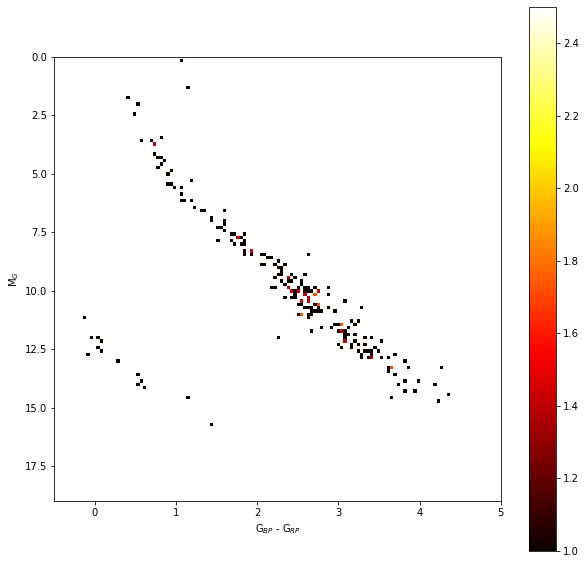

In [19]:
#build hr diagram
histogram, xedges, yedges = np.histogram2d(
   pio10_stars['bp_rp'], pio10_stars['g_abs'], bins=110)

histogram = np.ma.masked_where(histogram == 0.0, histogram) #map zero values
histogram = histogram.T #list bins with common y range

color_map = plt.cm.get_cmap("hot") #set colors for diagram
color_map.set_bad(color='white') #set color as white for masked values

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] #bounding box in data

#plotting

plt.figure(figsize=(10, 10))

plt.imshow(np.sqrt(histogram), origin='lower', cmap=color_map,
    extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2])
    )

plt.xlim(-0.5, 5)
plt.ylim(0, 19)

plt.colorbar()
plt.clim(1,2.5)

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')
plt.gca().invert_yaxis()
plt.savefig('pio10_stars_hr.png')

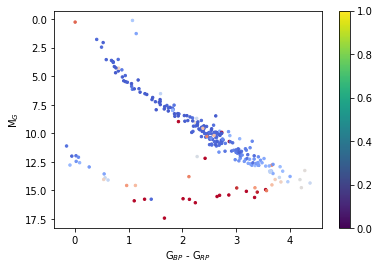

In [20]:
#color magnitude with stars removed from parallax error
cmap = plt.cm.get_cmap("coolwarm")
pio10_stars = pd.read_csv('pio10_results_error.csv')   #color magnitude including error stars

plt.scatter(pio10_stars['bp_rp'], pio10_stars['g_abs'], color = cmap(pio10_stars['parallax_error']*2), s = 6)

plt.colorbar()
plt.gca().invert_yaxis()

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')

plt.savefig("pio10_stars_error.png")

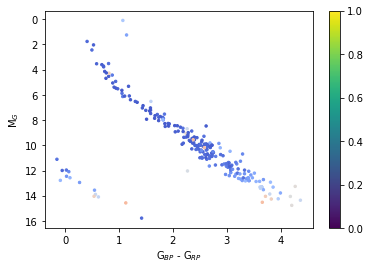

In [21]:
#color magnitude without stars removed from parallax error
pio10_stars = pio10_stars[pio10_stars['parallax_error'] <= 0.34]       #With error filter of .34

cmap = plt.cm.get_cmap("coolwarm")

plt.scatter(pio10_stars['bp_rp'], pio10_stars['g_abs'], color = cmap(pio10_stars['parallax_error']*2), s = 6)

plt.colorbar()
plt.gca().invert_yaxis()

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')

plt.savefig("pio10_stars_error_removed.png")

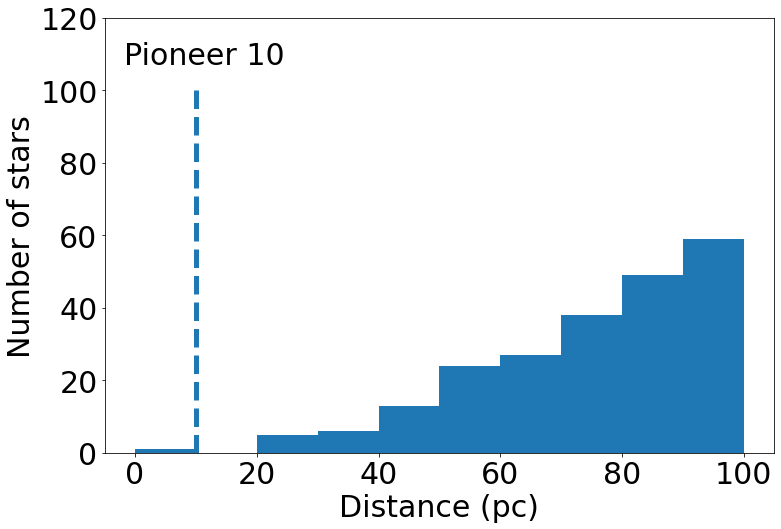

In [22]:
#distance histogram
pio10_stars = pd.read_csv('pio10_results.csv') #get csv

plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(12, 8))

plt.hist(abs(1000/pio10_stars['parallax']), bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) #plot parallax (mas) converted to distance (pc) in histogram
plt.plot([10, 10], [0, 100], '--', linewidth=5, c='#1f77b4')

plt.xlabel("Distance (pc)")
plt.ylabel("Number of stars")
plt.figtext(0.24, 0.8, "Pioneer 10", wrap=True, horizontalalignment='center')

plt.ylim(0, 120)

plt.savefig("pio10_stars_dist.png")
plt.show()

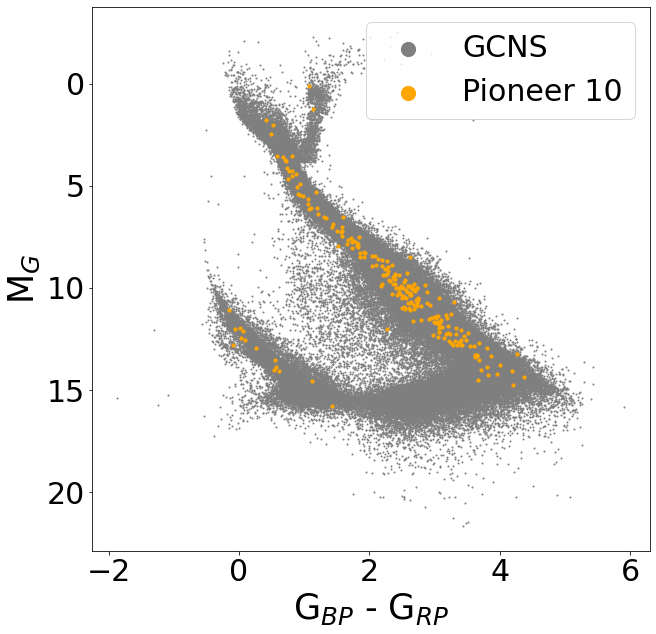

In [23]:
#HR with gcns in background
gcns = pd.read_csv('gcns_total.csv') #all stars in the GCNS database

plt.figure(figsize=(10, 10))

plt.scatter(gcns['bp_rp'], gcns['g_abs'], c = 'tab:gray', s = 1, label = "GCNS")
plt.scatter(pio10_stars['bp_rp'], pio10_stars['g_abs'], c = 'orange', s = 10, label = "Pioneer 10")

plt.gca().invert_yaxis()
plt.xlabel('G$_{BP}$ - G$_{RP}$', fontsize=35)
plt.ylabel('M$_G$', fontsize=35)

lgnd = plt.legend(loc='upper right')
lgnd.legendHandles[0]._sizes = [200]
lgnd.legendHandles[1]._sizes = [200]

plt.savefig("pio10_superset_hr.png")
plt.show()

In [24]:
star_results = pd.read_csv('pio10_results.csv')
star_results_error = pd.read_csv('pio10_results_error.csv')

star_results['time_total'] = star_results['time_total']/86400 #convert total time from seconds to hours
star_results_error['time_total'] =  star_results_error['time_total']/86400

print(star_results)
print(star_results_error)

star_results.to_csv('pio10_results.csv')
star_results_error.to_csv('pio10_results_error.csv')

     Unnamed: 0            source_id          ra        dec      g_abs  \
0             0  6040170361314010368  241.209447 -29.372270  12.656759   
1             7  6040374526875038336  240.886424 -29.236631  10.509056   
2            14  6040379371598261888  240.704638 -29.159567  10.107287   
3            21  6233452028580863744  236.874676 -27.919921  10.172965   
4            35  6233827825340751360  236.903705 -27.857453  10.939351   
..          ...                  ...         ...        ...        ...   
217        3918   147448842907369216   71.176794  25.428486  12.938326   
218        4140   147469115153030528   71.982516  25.579519   9.977690   
219        4433   153279243832437376   74.081388  25.695916  12.402469   
220        4533  3419918875386344576   74.532503  25.805848  12.564852   
221        4669  3420282985533933824   74.990215  25.854341   9.308213   

        bp_rp   parallax  parallax_error       dist                      date  \
0    3.398704  11.812105      